In [3]:
%load_ext autoreload
%autoreload 2

from discontinuum.providers import usgs
from discontinuum.utils import aggregate_to_daily

import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# configuration
# Choptank River at Greensboro, MD
#site = "01491000" 
#start_date = "1979-10-01"
#end_date = "2011-09-30"
#parameter_cd = "00631" #5 digit USGS code

# SF Coeur D Alene River 
site = "12413470"
#parameter_cd = "00665"
parameter_cd = "00631"
start_date = "1988-10-01" 
end_date = "2021-09-30" 

In [11]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(site=site, start_date=start_date, end_date=end_date, pcode=parameter_cd)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/nwis.py:180: UserWarning: WARNING: Starting in March 2024, the NWIS qw data endpoint is retiring and no longer receives updates. For more information, refer to https://waterdata.usgs.gov.nwis/qwdata and https://doi-usgs.github.io/dataRetrieval/articles/Status.html or email CompTools@usgs.gov.
  warnings.warn(('WARNING: Starting in March 2024, the NWIS qw data endpoint is '


In [12]:
# fit model

from discontinuum.models import WRTDSModel

model = WRTDSModel()
model.fit(target=training_data['concentration'],
          covariates=training_data[['time','flow']])

MAP ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3% 0:01:23 logp = -194.57, ||grad|| = 0.0059985

<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

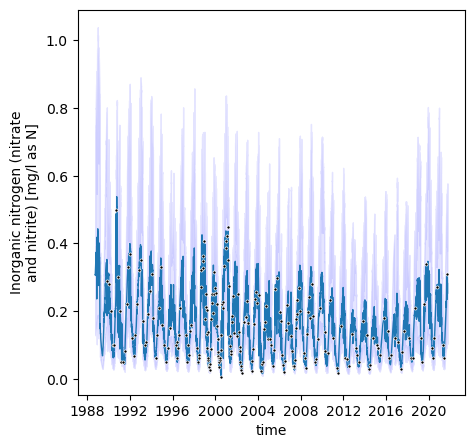

In [13]:
# plot result

model.plot_concentration(daily[['time','flow']])